In [40]:
# !pip install numpy pandas matplotlib sympy scipy

# problem 2

A servo motor can be described by the following state equation

$$
\begin{align*}
\begin{bmatrix}
\dot{x_1} \\
\dot{x_2}
\end{bmatrix}
&=
\begin{bmatrix}
0 & 1 \\
0 & -1
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0 \\
1
\end{bmatrix}
u(t)
\end{align*}
$$

Where x_1  is the angular position, x_2  is the angular velocity of the motor shaft and u(t) is the applied voltage. A control system is designed to drive the angular position to zero using the input u(t). Find an optimum input u(t) that derives the system from 30 degrees angular position of the shaft to zero in 25 seconds while minimizing the cost function given by


\begin{align*}
J&= 1/2  \begin{bmatrix}
x_1 (25) \\
x_2 (25)
\end{bmatrix}^T P \begin{bmatrix}
x_1 (25) \\
x_2 (25)
\end{bmatrix} + 1/2 \int_{0}^{25} \left( \begin{bmatrix}
x_1 (t) \\
x_2 (t)
\end{bmatrix}^T Q \begin{bmatrix}
x_1 (t) \\
x_2 (t)
\end{bmatrix} + ru^2 (t) \right) dt
\end{align*}



a.	Assuming fixed final state, solve for optimal feedback control for two different sets of P, Q, and r.

b.	How is the optimal cost inluenced by the selection of P, Q, and r?

c.	Rework parts (a) and (b) if the final state is free.



## imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import scipy as sc

from sympy import symbols, Eq, solve, simplify, MatrixSymbol
from pprint import pprint
from IPython.display import display, Math

In [50]:
n_states = 2


x_k = sp.MatrixSymbol('x_k', n_states, 1)
x_kplus1 = sp.MatrixSymbol('x_{k+1}', n_states, 1)
x_0 = sp.MatrixSymbol('x_0', n_states, 1)
a = sp.MatrixSymbol('A', n_states, n_states)
b = sp.MatrixSymbol('B', n_states, n_states)
u_k = sp.MatrixSymbol('u_k', n_states, 1)
u_star = sp.MatrixSymbol('u^*', n_states, 1)
k = symbols('k')
N = symbols('N')
i_sympy = symbols('i')
cost_L = symbols('L^k')
lmda_k = sp.MatrixSymbol(f'lambda_{k}', n_states, 1)
lmda_kplus1 = sp.MatrixSymbol(f'lambda_{k+1}', n_states, 1)
lmda_N = sp.MatrixSymbol(f'lambda_{N}', n_states, 1)
R = sp.MatrixSymbol('R', n_states, n_states)
G_n = sp.MatrixSymbol('G_n', n_states, n_states)
r_N = sp.MatrixSymbol('r_N', n_states, 1)
S_k = sp.MatrixSymbol('S_k', n_states, n_states)
S_kplus1 = sp.MatrixSymbol('S_{k+1}', n_states, n_states)
S_N = sp.MatrixSymbol('S_N', n_states, n_states)
Q = sp.MatrixSymbol('Q', n_states, n_states)



## Define the system dynamics
N_val = 2
a_val = sp.Matrix([[-1/2, 1/2], [3, -1]])
b_val = sp.Matrix([[2, 1], [2, 0]])
R_val = sp.Matrix([[2, 0], [0, 1]])
x0 = sp.Matrix([1, 2])
rN = sp.Matrix([0, 0])
r_val = 1
input_cost = r_val/2 * u_k.T * R * u_k
input_cost2 = 1
Q_val = sp.Matrix([[1, 0], [0, 1]])  * 0
Sn_val = 20 * sp.eye(n_states)


Jnot = .5 * sp.Sum(input_cost, (k, 0, N-1))
J_deadbeat = sp.Sum(input_cost2, (k, 0, N-1))


def f(x, u):
    val = a*x + b*u
    return val


display(Math(r'system\ dynamics: x_{k+1} = ' + sp.latex(f(x_k, u_k))))
display(Math(r'cost\ function: J_0 = ' + sp.latex(Jnot)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 1.0, 'Zero input response')

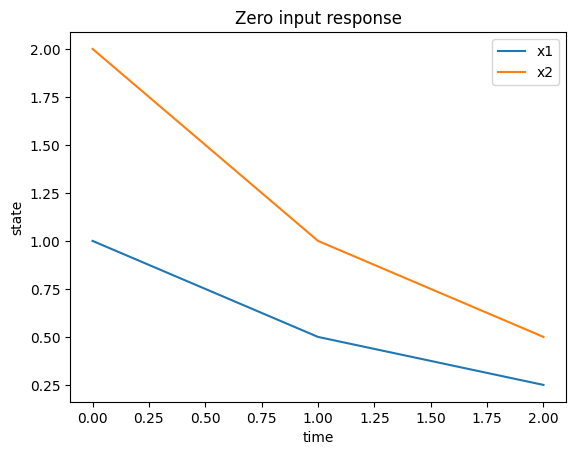

In [51]:
# finding the homogeneous solution of the differential equation


xk = x0
uk = sp.Matrix([0, 0])
state_values0 = [xk]

for _ in range(N_val):
    xk1 = f(xk, uk)
    xk = xk1
    state_values0.append(xk)
    
state_values0 = [x.subs(a, a_val).subs(b, b_val) for x in state_values0]
state_values0 = np.array(state_values0).reshape(N_val+1, n_states)

plt.plot(state_values0[:, 0], label='x1')
plt.plot(state_values0[:, 1], label='x2')
plt.legend()
plt.xlabel('time')
plt.ylabel('state')
plt.title('Zero input response')

## part a
### fixed final state

In [52]:

print("path cost:")
display(Math(r'J_{0} = ' + sp.latex(Jnot)))

print("so, the hamioltonian is:")
H_k = input_cost + lmda_kplus1.T * (f(x_k, u_k))
display(Math(r'H^k = ' + sp.latex(H_k)))

print("the costate equation is:")
costate_eqn = sp.diff(H_k, x_k)
costate_eqn = Eq(costate_eqn, lmda_k)
display(Math(r'\frac{dH^k}{dx_k} = ' + sp.latex(costate_eqn)) )

print("the state equation is:")
state_eqn = sp.diff(H_k, lmda_kplus1)
display(Math(r'\frac{dH^k}{d\lambda_{k+1}} = x_{k+1} =' + sp.latex(state_eqn)) )

print("the stationarity equation is:")
stationarity_eqn = sp.diff(H_k, u_k)
display(Math(r'\frac{dH^k}{du_k} = 0 =' + sp.latex(stationarity_eqn)) )


## manual part: (for now)
lmda_k_with_lmdaN = a.T ** (N - k) * lmda_N
display(Math(r'\lambda_k = ' + sp.latex(lmda_k_with_lmdaN)))
u_k1 = -R ** -1 * b.T * lmda_kplus1
display(Math(r'u_k = ' + sp.latex(u_k1)))


u_k1 = u_k1.subs(lmda_kplus1, lmda_k_with_lmdaN).subs(k, k+1)
display(Math(r'u_k = ' + sp.latex(u_k1)))
x_k1 = f(x_k, u_k1)
display(Math(r'x_{k+1} = ' + sp.latex(x_k1)))

xk = x_0
for _ in range(N_val):
    xk1 = x_k1.subs(x_k, xk)
    xk = xk1 
print("we get:")
display(Math(r'x_N = ' + sp.latex(xk)))
print("which is the same as:")
Gk = sp.Sum(a**(k-i_sympy-1) * b * R**-1 * b.T * (a.T)**(N-i_sympy-1) , (i_sympy, 0, k-1))
Gn = Gk.subs(k, N)
display(Math(r'x_N = A^{N}x_0 ' + sp.latex(-Gn) + sp.latex(lmda_N)))
print("where")
display(Math(r'G_N = ' + sp.latex(Gn)))
print("we can precalculate the Gn term:")
gn_val = Gn.subs(a, a_val).subs(b, b_val).subs(R, R_val).subs(N, N_val).simplify().doit()
gn_val = np.array(gn_val).astype(np.float64)
print(gn_val)

print("we can also precalculate the costate values:")
val = rN - (a**N_val*x_0).subs(a, a_val).subs(N, N_val).subs(x_0, x0).simplify().doit()
lmda_n_val = -sc.linalg.inv(gn_val) @ val
display(Math(r'\lambda_N = ' + sp.latex(lmda_n_val)))
lmdak_val = lmda_n_val
lmda_n_values = [lmda_n_val]
for i in range(N_val, 0, -1):
    lmdak_val = a_val.T @ lmdak_val
    lmda_n_values.append(lmdak_val)
lmda_n_values = np.array(lmda_n_values).reshape(N_val+1, n_states)

uk_star = u_k1.subs(lmda_N, lmda_n_val).simplify()
display(Math(r'u^* = ' + sp.latex(uk_star)))

path cost:


<IPython.core.display.Math object>

so, the hamioltonian is:


<IPython.core.display.Math object>

the costate equation is:


<IPython.core.display.Math object>

the state equation is:


<IPython.core.display.Math object>

the stationarity equation is:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

we get:


<IPython.core.display.Math object>

which is the same as:


<IPython.core.display.Math object>

where


<IPython.core.display.Math object>

we can precalculate the Gn term:
[[ 3.25  0.5 ]
 [ 0.5  19.  ]]
we can also precalculate the costate values:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 1.0, 'Optimal input')

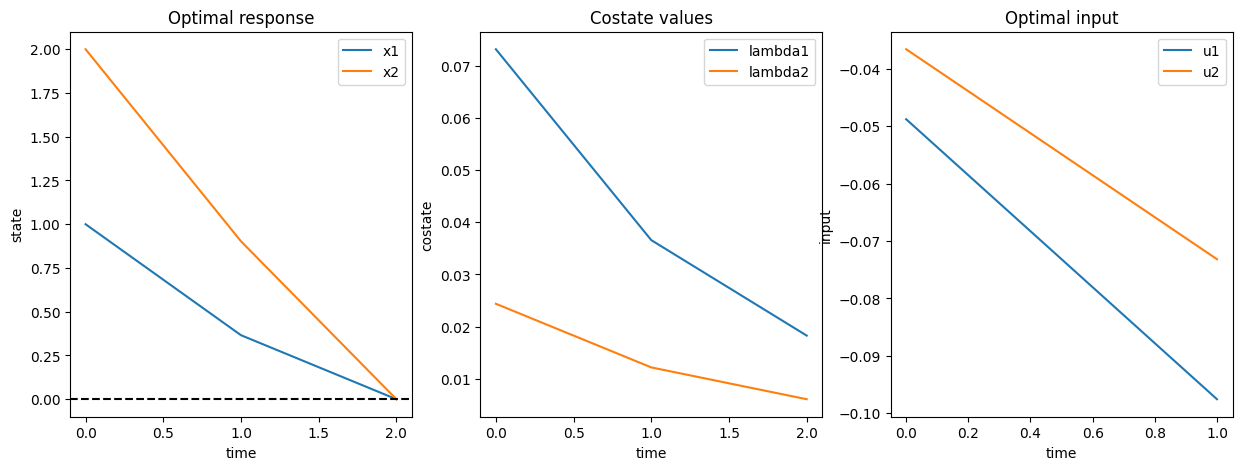

In [53]:
## simulate the system with the optimal input

xk = x0
state_values = [xk]
input_values = []   
for i in range(N_val):
    uk_val = uk_star.subs(k, i).subs(R, R_val).subs(a, a_val).subs(b, b_val).subs(N, N_val)
    uk_val = uk_val.simplify().doit()
    uk_val = np.array(uk_val).astype(np.float64)
    xk = a_val @ xk + b_val @ uk_val
    state_values.append(xk)
    input_values.append(uk_val)

state_values = np.array(state_values).reshape(N_val+1, n_states)
input_values = np.array(input_values).reshape(N_val, n_states)

figrow = 1
figcol = 3
fig, axes = plt.subplots(figrow, figcol, figsize=(figcol*5, figrow*5))
axes = axes.flatten()
axes = (ax for ax in axes)

ax = next(axes)
ax.plot(state_values[:, 0], label='x1')
ax.plot(state_values[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Optimal response')

ax = next(axes)
ax.plot(lmda_n_values[:, 0], label='lambda1')
ax.plot(lmda_n_values[:, 1], label='lambda2')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('costate')
ax.set_title('Costate values')

ax = next(axes)
ax.plot(input_values[:, 0], label='u1')
ax.plot(input_values[:, 1], label='u2')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('input')
ax.set_title('Optimal input')


# deadbeat control
The deadbeat control is a control strategy that makes the system reach the desired state in a finite time. The deadbeat control is given by the following equation:

$$u(k) = -Kx(k)$$

where $K$ is the control gain matrix. 
in deadbeat control, the Q matrix is set to some very large value, and the R matrix is set to some very small value. 

In [54]:
Q_deadbeat = sp.Matrix([[1, 0], [0, 1]])  * 1
R_deadbeat = sp.Matrix([[1, 0], [0, 1]])  * 0
##############################################


sk = a.T * (S_kplus1 - S_kplus1 * b *(b.T * S_kplus1 * b + R)**-1 * b.T * S_kplus1) * a + Q
display(Math(r'S_k = ' + sp.latex(sk)))

print("we can precalculate the Sk term:")

sk_val = Sn_val
sk_vals = [sk_val]
for i in range(N_val, 0, -1):
    sk_val = sk.subs(S_kplus1, sk_val).subs(a, a_val).subs(b, b_val).subs(R, R_deadbeat).subs(Q, Q_deadbeat).subs(N, N_val).simplify().doit()
    # sk_val = np.array(sk_val).astype(np.float64)
    sk_vals.append(sk_val)
sk_vals = np.array(sk_vals).reshape(N_val+1, n_states, n_states)
sk_vals = sk_vals[::-1, :, :]

kk = (b.T * S_kplus1 * b + R)**-1 * b.T * S_kplus1 * a
display(Math(r'K_k = ' + sp.latex(kk)))

k_vals = []
for i in range(N_val):
    sk_plus1 = sk_vals[i+1]
    val = kk.subs(a, a_val).subs(b, b_val).subs(R, R_deadbeat).subs(S_kplus1, sp.Matrix(sk_plus1)).simplify().doit()
    k_vals.append(np.array(val).astype(np.float64))
    
    
xk = x0
uk_vals2 = []
state_values2 = [xk]
for i in range(N_val):
    uk_val = -k_vals[i] @ xk
    xk = a_val @ xk + b_val @ uk_val
    uk_vals2.append(uk_val)
    state_values2.append(xk)

state_values2 = np.array(state_values2).reshape(N_val+1, n_states)
uk_vals2 = np.array(uk_vals2).reshape(N_val, n_states)

<IPython.core.display.Math object>

we can precalculate the Sk term:


<IPython.core.display.Math object>

Text(0.5, 1.0, 'Optimal input, deadbeat')

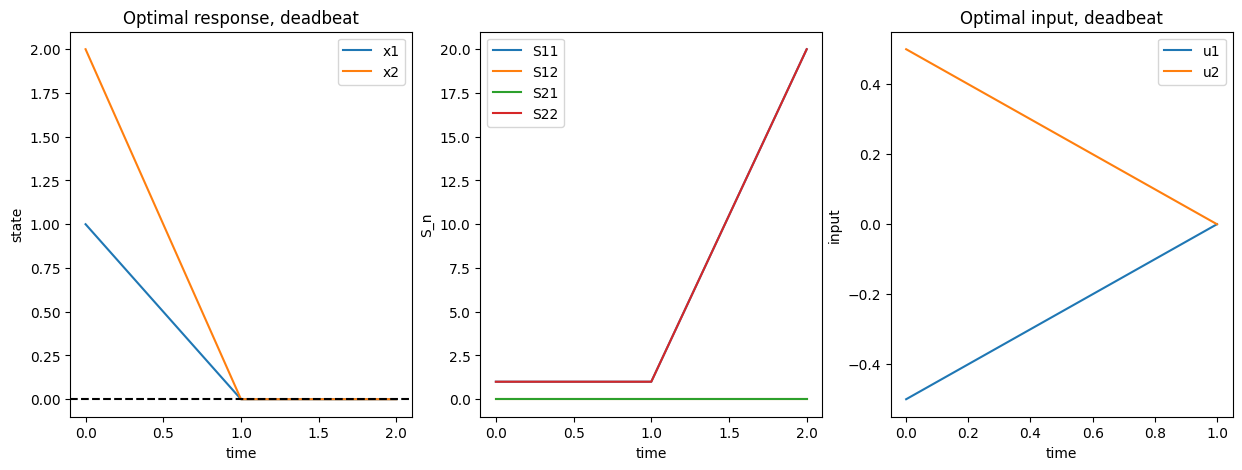

In [55]:
figrow = 1
figcol = 3
fig, axes = plt.subplots(figrow, figcol, figsize=(figcol*5, figrow*5))
axes = axes.flatten()
axes = (ax for ax in axes)

ax = next(axes)
ax.plot(state_values2[:, 0], label='x1')
ax.plot(state_values2[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Optimal response, deadbeat')

ax = next(axes)
ax.plot(sk_vals[:, 0, 0], label='S11')
ax.plot(sk_vals[:, 0, 1], label='S12')
ax.plot(sk_vals[:, 1, 0], label='S21')
ax.plot(sk_vals[:, 1, 1], label='S22')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel(r'S_n')

ax = next(axes)
ax.plot(uk_vals2[:, 0], label='u1')
ax.plot(uk_vals2[:, 1], label='u2')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('input')
ax.set_title('Optimal input, deadbeat')

# optimal closed-loop control, free final state

In [56]:
sk = a.T * (S_kplus1 - S_kplus1 * b *(b.T * S_kplus1 * b + R)**-1 * b.T * S_kplus1) * a + Q
display(Math(r'S_k = ' + sp.latex(sk)))

print("we can precalculate the Sk term:")

sk_val = Sn_val
sk_vals = [sk_val]
for i in range(N_val, 0, -1):
    sk_val = sk.subs(S_kplus1, sk_val).subs(a, a_val).subs(b, b_val).subs(R, R_val).subs(Q, Q_val).subs(N, N_val).simplify().doit()
    # sk_val = np.array(sk_val).astype(np.float64)
    sk_vals.append(sk_val)
sk_vals = np.array(sk_vals).reshape(N_val+1, n_states, n_states)
sk_vals = sk_vals[::-1, :, :]

kk = (b.T * S_kplus1 * b + R)**-1 * b.T * S_kplus1 * a
display(Math(r'K_k = ' + sp.latex(kk)))

k_vals = []
for i in range(N_val):
    sk_plus1 = sk_vals[i+1]
    val = kk.subs(a, a_val).subs(b, b_val).subs(R, R_val).subs(S_kplus1, sp.Matrix(sk_plus1)).simplify().doit()
    k_vals.append(np.array(val).astype(np.float64))
    
    
xk = x0
uk_vals3 = []
state_values3 = [xk]
for i in range(N_val):
    uk_val = -k_vals[i] @ xk
    xk = a_val @ xk + b_val @ uk_val
    uk_vals3.append(uk_val)
    state_values3.append(xk)

state_values3 = np.array(state_values3).reshape(N_val+1, n_states)
uk_vals3 = np.array(uk_vals3).reshape(N_val, n_states)

<IPython.core.display.Math object>

we can precalculate the Sk term:


<IPython.core.display.Math object>

Text(0.5, 1.0, 'Optimal input, closed loop')

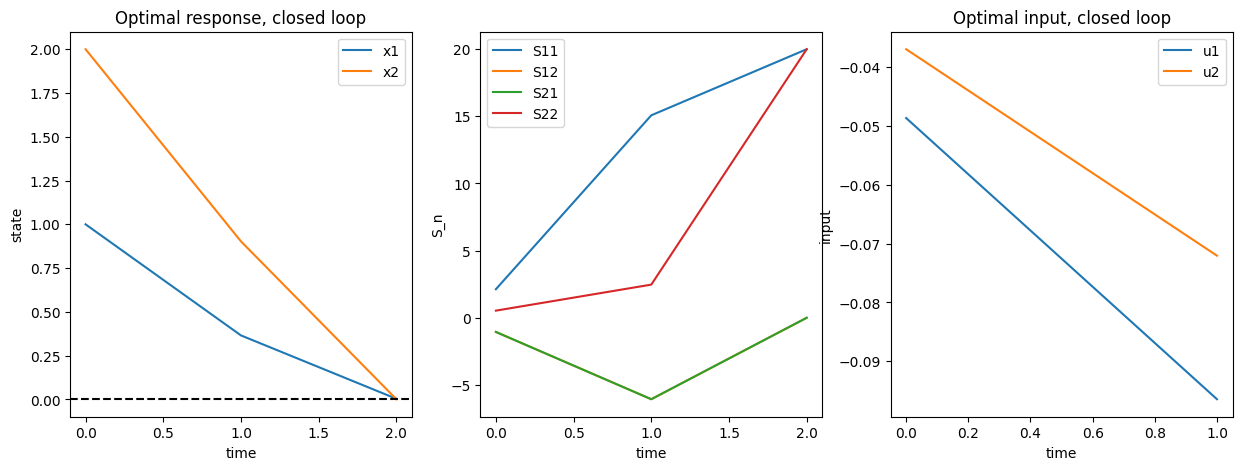

In [57]:
figrow = 1
figcol = 3
fig, axes = plt.subplots(figrow, figcol, figsize=(figcol*5, figrow*5))
axes = axes.flatten()
axes = (ax for ax in axes)

ax = next(axes)
ax.plot(state_values3[:, 0], label='x1')
ax.plot(state_values3[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Optimal response, closed loop')

ax = next(axes)
ax.plot(sk_vals[:, 0, 0], label='S11')
ax.plot(sk_vals[:, 0, 1], label='S12')
ax.plot(sk_vals[:, 1, 0], label='S21')
ax.plot(sk_vals[:, 1, 1], label='S22')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel(r'S_n')

ax = next(axes)
ax.plot(uk_vals3[:, 0], label='u1')
ax.plot(uk_vals3[:, 1], label='u2')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('input')
ax.set_title('Optimal input, closed loop')

# comparing trajectories

Text(0.5, 1.0, 'optimal response')

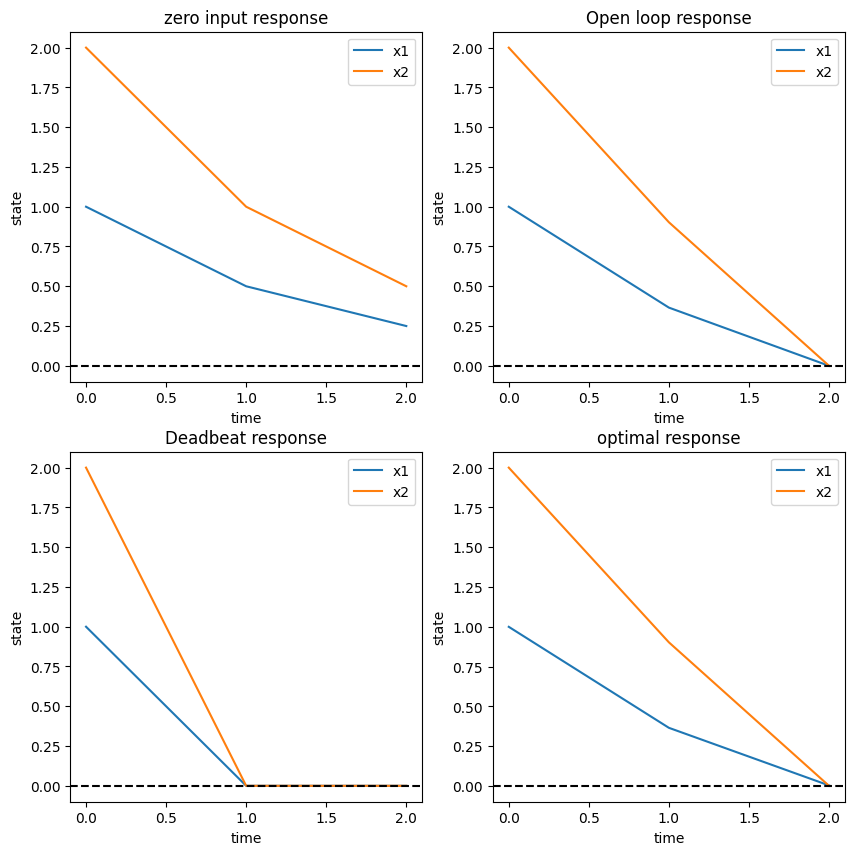

In [58]:
figrow = 2
figcol = 2
fig, axes = plt.subplots(figrow, figcol, figsize=(figcol*5, figrow*5))
axes = (ax for ax in axes.flatten())


ax = next(axes)
ax.plot(state_values0[:, 0], label='x1')
ax.plot(state_values0[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('zero input response')

ax = next(axes)
ax.plot(state_values[:, 0], label='x1')
ax.plot(state_values[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Open loop response')

ax = next(axes)
ax.plot(state_values2[:, 0], label='x1')
ax.plot(state_values2[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('Deadbeat response')

ax = next(axes)
ax.plot(state_values3[:, 0], label='x1')
ax.plot(state_values3[:, 1], label='x2')
ax.axhline(0, color='black', linestyle='--')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('state')
ax.set_title('optimal response')
